In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

#for model-building
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.manifold import TSNE

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /Users/ccaminha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ccaminha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ccaminha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ccaminha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ccaminha/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ccaminha/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ccaminha/nltk_data...
[n

In [2]:
df_dados= pd.read_csv('../../dados classificacao texto/disaster/train.csv')

df_dados['word_count'] = df_dados['text'].apply(lambda x: len(str(x).split()))

df_dados['char_count'] = df_dados['text'].apply(lambda x: len(str(x)))

df_dados = df_dados.sample(frac=1)

df_dados

,id,keyword,location,text,target,word_count,char_count
5898,8423,sandstorm,USA,Watch This Airport Get Swallowed Up By A Sands...,1,14,91
5318,7593,outbreak,"New York, NY",An outbreak of Legionnaires' disease in New Yo...,1,17,133
6370,9102,suicide%20bomb,NaN,...//..// whao.. Pic of 16yr old PKK suicide b...,1,18,124
2930,4211,drowned,WorldWideWeb,#DW Hundreds feared drowned as migrant boat ca...,1,15,114
4854,6913,mass%20murderer,NaN,White people I know you worry tirelessly about...,1,24,130
...,...,...,...,...,...,...,...
5640,8043,refugees,tripoli international airport,@KristinDavis @UN @Refugees Thank you @UN and ...,0,21,141
4710,6697,landslide,NaN,@Morning_Joe @Reince @PressSec Joe ur so smart...,0,24,140
3931,5589,flood,NaN,Internet basics: the flood defective intertiss...,1,15,114
2591,3719,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0,19,106


In [3]:
df_dados['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [4]:
print('Disaster tweets=',df_dados[df_dados['target']==1]['word_count'].mean()) #Disaster tweets
print('Non-Disaster tweets = ',df_dados[df_dados['target']==0]['word_count'].mean()) #Non-Disaster tweets

Disaster tweets= 15.167532864567411
Non-Disaster tweets =  14.704744357438969


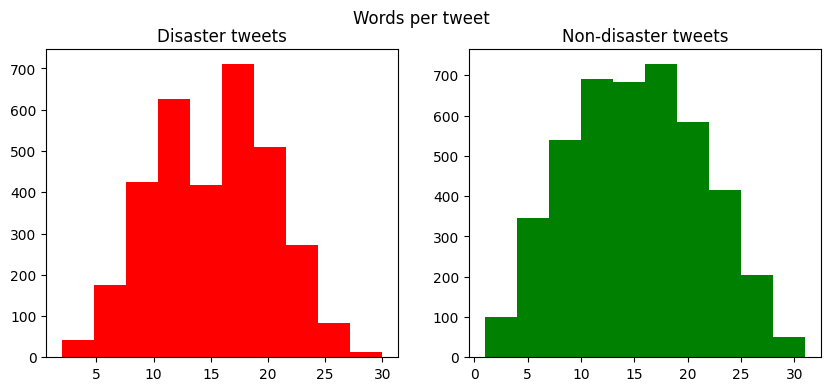

In [5]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_dados[df_dados['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=df_dados[df_dados['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

In [6]:
print('Disaster tweets=',df_dados[df_dados['target']==1]['char_count'].mean()) #Disaster tweets
print('Non-Disaster tweets=',df_dados[df_dados['target']==0]['char_count'].mean()) #Non-Disaster tweets

Disaster tweets= 108.11342097217977
Non-Disaster tweets= 95.70681713496084


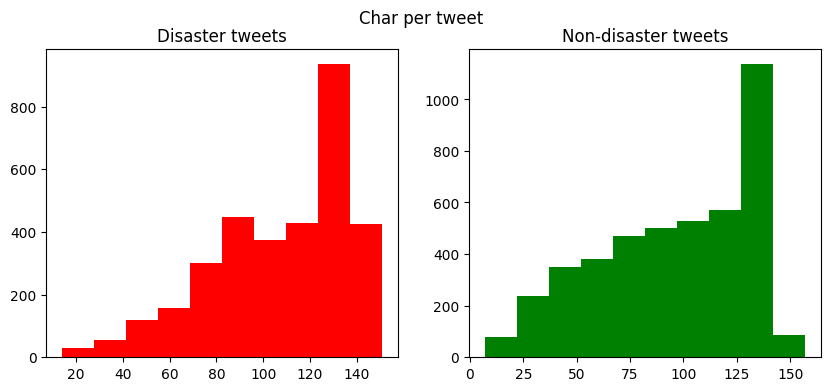

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_dados[df_dados['target']==1]['char_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=df_dados[df_dados['target']==0]['char_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Char per tweet')
plt.show()

In [8]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() # coloca em caixa baixa
    text=text.strip()  # remove espaços em branco do início e final
    text=re.compile('<.*?>').sub('', text) #remove todas as tags HTML ou XML
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  # troca pontuação por espaço
    text = re.sub('\s+', ' ', text)  # tira espaço em branco repetido
    text = re.sub(r'\[[0-9]*\]',' ',text) # remove numeros entre colchetes
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip()) # remove alguns caracteres que não ajudam
    text = re.sub(r'\d',' ',text) # remove números
    text = re.sub(r'\s+',' ',text) # tira espaço em branco repetido
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)


#LEMMATIZATION

# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))


df_dados['clean_text'] = df_dados['text'].apply(lambda x: finalpreprocess(x))


df_dados

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/var/folders/1x/kdrp4_m91klf6jl61h6wh6ym0000gn/T/ipykernel_11549/1584654582.py:7: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)  # tira espaço em branco repetido


,id,keyword,location,text,target,word_count,char_count,clean_text
5898,8423,sandstorm,USA,Watch This Airport Get Swallowed Up By A Sands...,1,14,91,watch airport get swallow sandstorm minute htt...
5318,7593,outbreak,"New York, NY",An outbreak of Legionnaires' disease in New Yo...,1,17,133,outbreak legionnaire disease new york kill lea...
6370,9102,suicide%20bomb,NaN,...//..// whao.. Pic of 16yr old PKK suicide b...,1,18,124,whao pic yr old pkk suicide bomber detonate bo...
2930,4211,drowned,WorldWideWeb,#DW Hundreds feared drowned as migrant boat ca...,1,15,114,dw hundred fear drowned migrant boat capsize l...
4854,6913,mass%20murderer,NaN,White people I know you worry tirelessly about...,1,24,130,white people know worry tirelessly black black...
...,...,...,...,...,...,...,...,...
5640,8043,refugees,tripoli international airport,@KristinDavis @UN @Refugees Thank you @UN and ...,0,21,141,kristindavis un refugee thank un refugee help ...
4710,6697,landslide,NaN,@Morning_Joe @Reince @PressSec Joe ur so smart...,0,24,140,morning joe reince presssec joe ur smart u run...
3931,5589,flood,NaN,Internet basics: the flood defective intertiss...,1,15,114,internet basic flood defective intertissue sou...
2591,3719,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0,19,106,black eye space battle occur star involve flee...


In [9]:
#Bag of words
vectorizer = CountVectorizer()
X_cross = vectorizer.fit_transform(df_dados['clean_text'])

#Tf-Idf
# tfidf_vectorizer = TfidfVectorizer(use_idf=True)
# X_cross = tfidf_vectorizer.fit_transform(df_dados['clean_text'])

y_cross = df_dados['target']

In [ ]:
X_cross[0]

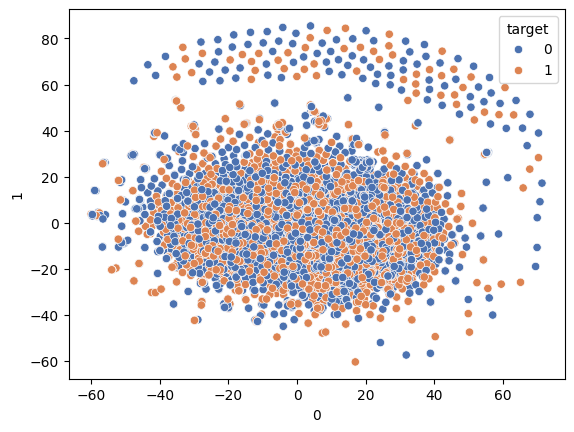

In [10]:
tsne = TSNE(n_components=2, init="random", random_state=0, learning_rate='auto')
array_red = tsne.fit_transform(X_cross) 

df_tsne = pd.DataFrame(array_red)

df_tsne['target'] = y_cross

sns.scatterplot(data=df_tsne, x=df_tsne[0], y=df_tsne[1], hue=df_tsne['target'], palette="deep")
plt.show()

In [11]:
def getModel():
    return LogisticRegression(max_iter=200)
#     return DecisionTreeClassifier()
    # return RandomForestClassifier(n_jobs = 14)

In [12]:
scores = cross_val_score(getModel(),X_cross,y_cross,cv=10)

np.mean(scores)

np.float64(0.8003402416353671)

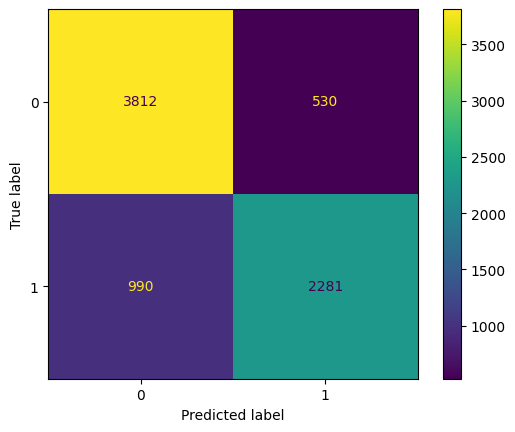

In [13]:
predicoes = cross_val_predict(getModel(),X_cross,y_cross,cv=10)

cm = confusion_matrix(df_dados['target'], predicoes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()

plt.show()